## MNIST digits based on leverage score

This notebook trains a t-SVGP model and plots MNIST digits on the basis of leverage score.

The Figure 2(b) of the paper is constructed using this notebook.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf

import sys
sys.path.append("..")
sys.path.append("../../..")

from src.models.tsvgp_cont import t_SVGP_cont, OnlineGP
from src.models.utils import piv_chol, compute_lev, memory_picker
from mnist_utils import load_mnist, optimize_online_model_minibatch

## Load split-MNIST data

In [2]:
train_tasks, test_tasks = load_mnist(seed=33)

# Merge all tasks into one
all_train_tasks = (train_tasks[0].copy(), train_tasks[1].copy())
all_test_tasks = (test_tasks[0].copy(), test_tasks[1].copy())

## Initialize model

In [3]:
Z = all_train_tasks[0][:300]
mem = (all_train_tasks[0][:1], all_train_tasks[1][:1])

m_cont = t_SVGP_cont(
    likelihood=gpflow.likelihoods.Softmax(10),
    kernel = gpflow.kernels.Matern52(),
    inducing_variable= Z,
    num_latent_gps=10,
)

In [4]:
gpflow.utilities.set_trainable(m_cont.inducing_variable.Z, False)

m_online = OnlineGP(m_cont, opt_hypers=tf.optimizers.Adam(learning_rate=0.01), n_steps=10, lambda_lr=0.1, 
                    Z_picker=piv_chol, memory=mem, num_mem=400, memory_picker=memory_picker)

2023-06-10 12:19:01.937061: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Optimize

In [5]:
nlpd, acc = optimize_online_model_minibatch(m_online, all_train_tasks, all_test_tasks, 
                                            minibatch_size=4000, n_hyp_opt_steps=50)

2023-06-10 12:20:31.788311: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-06-10 12:20:31.793206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
print(f"NLPD: {nlpd[-1]}")
print(f"Accuracy: {acc[-1]}")

NLPD: 0.32098452326125215
Accuracy: 0.9074285714285715


## Calculate leverage score

In [7]:
lev, lamb = compute_lev(m_online.model, all_train_tasks[0], all_train_tasks[1])
tasks_plus_score = np.concatenate((all_train_tasks[0], all_train_tasks[1], lev[..., None]), axis=1)
sorted_lev_idx = np.argsort(lev)
sorted_lev_idx = np.flip(sorted_lev_idx)

## Plotting

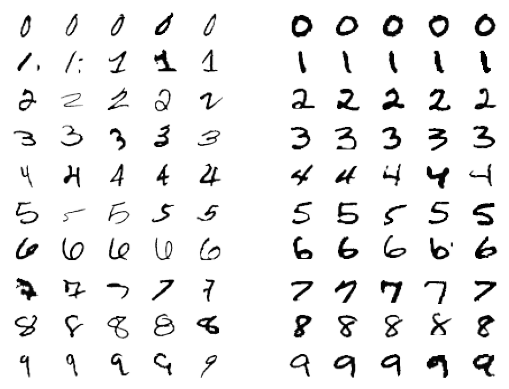

In [8]:
fig, axs = plt.subplots(10, 11)

for digit in range(10):
    idx = np.where(tasks_plus_score[:, -2] == digit)
    
    sorted_digit_lev_idx = np.argsort(tasks_plus_score[idx][:, -1])
    sorted_digit_lev_idx = np.flip(sorted_digit_lev_idx)
    
    sorted_digit_lev = tasks_plus_score[idx][sorted_digit_lev_idx]
    
    idx = 0
    for i in range(5):
        data = sorted_digit_lev[i]
        img = data[:-2].reshape((28, 28, 1))
        
        # Convert gray scale into RGBA
        inv_img = 1. - img
        alpha = img
        img = np.concatenate([inv_img, inv_img, inv_img, alpha], axis=-1)
        
        axs[digit][idx].imshow(img)
        axs[digit][idx].axis('off')
        idx = idx + 1
    
    axs[digit][idx].axis('off')
    idx = idx + 1
    for i in range(sorted_digit_lev.shape[0]-5, sorted_digit_lev.shape[0]):
        data = sorted_digit_lev[i]
        img = data[:-2].reshape((28, 28, 1))
        
        # Convert gray scale into RGBA
        inv_img = 1. - img
        alpha = img
        img = np.concatenate([inv_img, inv_img, inv_img, alpha], axis=-1)
        
        axs[digit][idx].imshow(img)
        axs[digit][idx].axis('off')
        idx = idx + 1

plt.show()